# About the dataset
Tyrosine Kinases ligands with bioactivity data, by Ricardo Romero Ochoa on kaggle
28,314 small compounds targeting tyrosine kinases, curated from the ChEMBL database

Ricardo Romero Ochoa. (2024). Tyrosine Kinases ligands with bioactivity data [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/8626441

# Aims & goals

Aim: train a model to predict how well a given compound targets receptor tyrosine kinases. Possible strategies include:

Strategy A: multi-label classification
- Input: chemical structure of the compound
- Label/Output: class (inactive, intermediate, active)

Strategy B: regression
- Input: chemical structure of the compound
- Output: IC50 value

Strategy C: binary classification
- Input: chemical structure of the compound
- Label/Output: class (inactive, active)


I will be focussing on multi-label classification (Strategy A).

# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drugs_dataset = pd.read_csv("./kinase_data_final_tox.csv")

In [2]:
# Get an overview of the data
drugs_dataset

,molecule_chembl_id,canonical_smiles,IC50,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,target,Druglikeness,Mutagenic,Tumorigenic,Reproductive Effective,Irritant
0,CHEMBL4557543,COc1cc(OC)c(Cl)c(-c2ccc3c(NC(=O)c4ccc(N5CCN(C)...,14.00,active,575.884,5.60640,2,7,7.853872,FGFR,8.89410,none,high,high,none
1,CHEMBL3904778,C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(OC)cc3OC)ncc2Br)c1,65.00,active,471.311,4.91670,2,7,7.187087,EGFR,-10.11200,high,low,low,low
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,10000.00,inactive,340.637,5.04890,0,2,5.000000,EGFR,0.70500,none,none,none,none
3,CHEMBL604712,CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]...,10000.00,inactive,376.407,3.56360,2,3,5.000000,ABL,1.01070,none,none,none,none
4,CHEMBL556684,COc1cc(O)c2c(c1)C(=O)c1cc(C)c(O)c(O)c1C2=O,4.00,active,300.266,1.89582,3,6,8.397940,EGFR,-0.97635,low,none,none,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28309,CHEMBL1822773,COc1ccc(CCC(=O)N/N=C2\C(=O)Nc3c(Cl)ccc(Cl)c32)cc1,2000.00,intermediate,392.242,3.40720,2,4,5.698970,MET,4.21000,none,high,high,low
28310,CHEMBL366580,Brc1cccc(Nc2ncnc3cc4c[nH]nc4cc23)c1,0.34,active,340.184,4.01220,2,4,9.468521,EGFR,1.30470,high,none,none,none
28311,CHEMBL2408503,O=C(COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1)Nc1cccc...,17600.00,inactive,466.287,4.94560,2,5,4.754487,ABL,0.33822,none,none,none,none
28312,CHEMBL1725279,Oc1c2ccccc2c2c3c(cccc13)N=N2,957.00,active,220.231,4.42740,1,3,6.019088,JAK,-5.87440,high,high,none,high


# About the dataset
- molecule_chembl_id: Identifier for the compound
- canonical_smiles: Simplified Molecular Input Line Entry System, used to describe molecular structure.
- IC50: concentration of a drug required to reduce the biological process by 50%
- class: Inactive (IC50 >= 10 000 nm); Active (IC50 =< 1000 nm); Intermediate (1000 < IC50 < 10 000 nm)
(IC50 > 10^9 nM) were converted to 1
- MW: molecular weight
- LogP: Water-octanol partition coefficient. Indicative of a compound's hydrophobicity/lipophilicity. logarithm of the ratio of a compound's concentration in octanol to its concentration in water. Greater logP means more lipophilic & non-polar compound.
- NumHDonors: Number of Hydrogen bond donors
- NumHAcceptors: Number of Hydrogen bond acceptors
- pIC50: -log10(IC50); larger pIC50 means more effective drug
- target: the tyrosine kinase(s) targeted by the compound
- Druglikeness: similarity of properties between the compound and existing drugs
- Mutagenic, Tumorigenic, Reproductive Effective, Irritant


In [3]:
import seaborn as sns

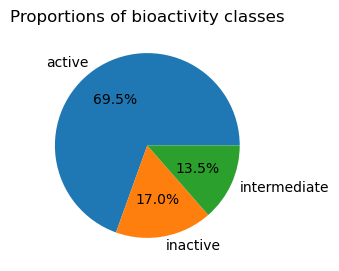

In [4]:
class_counts = drugs_dataset['class'].value_counts()
class_counts.plot(kind='pie', autopct='%1.1f%%', labels=class_counts.index, figsize=(3, 3))
plt.title('Proportions of bioactivity classes')
plt.ylabel('')
plt.show()

If our neural net guesses blindly, it will be correct 69.5% of the time. So our accuracy needs to be > 70%

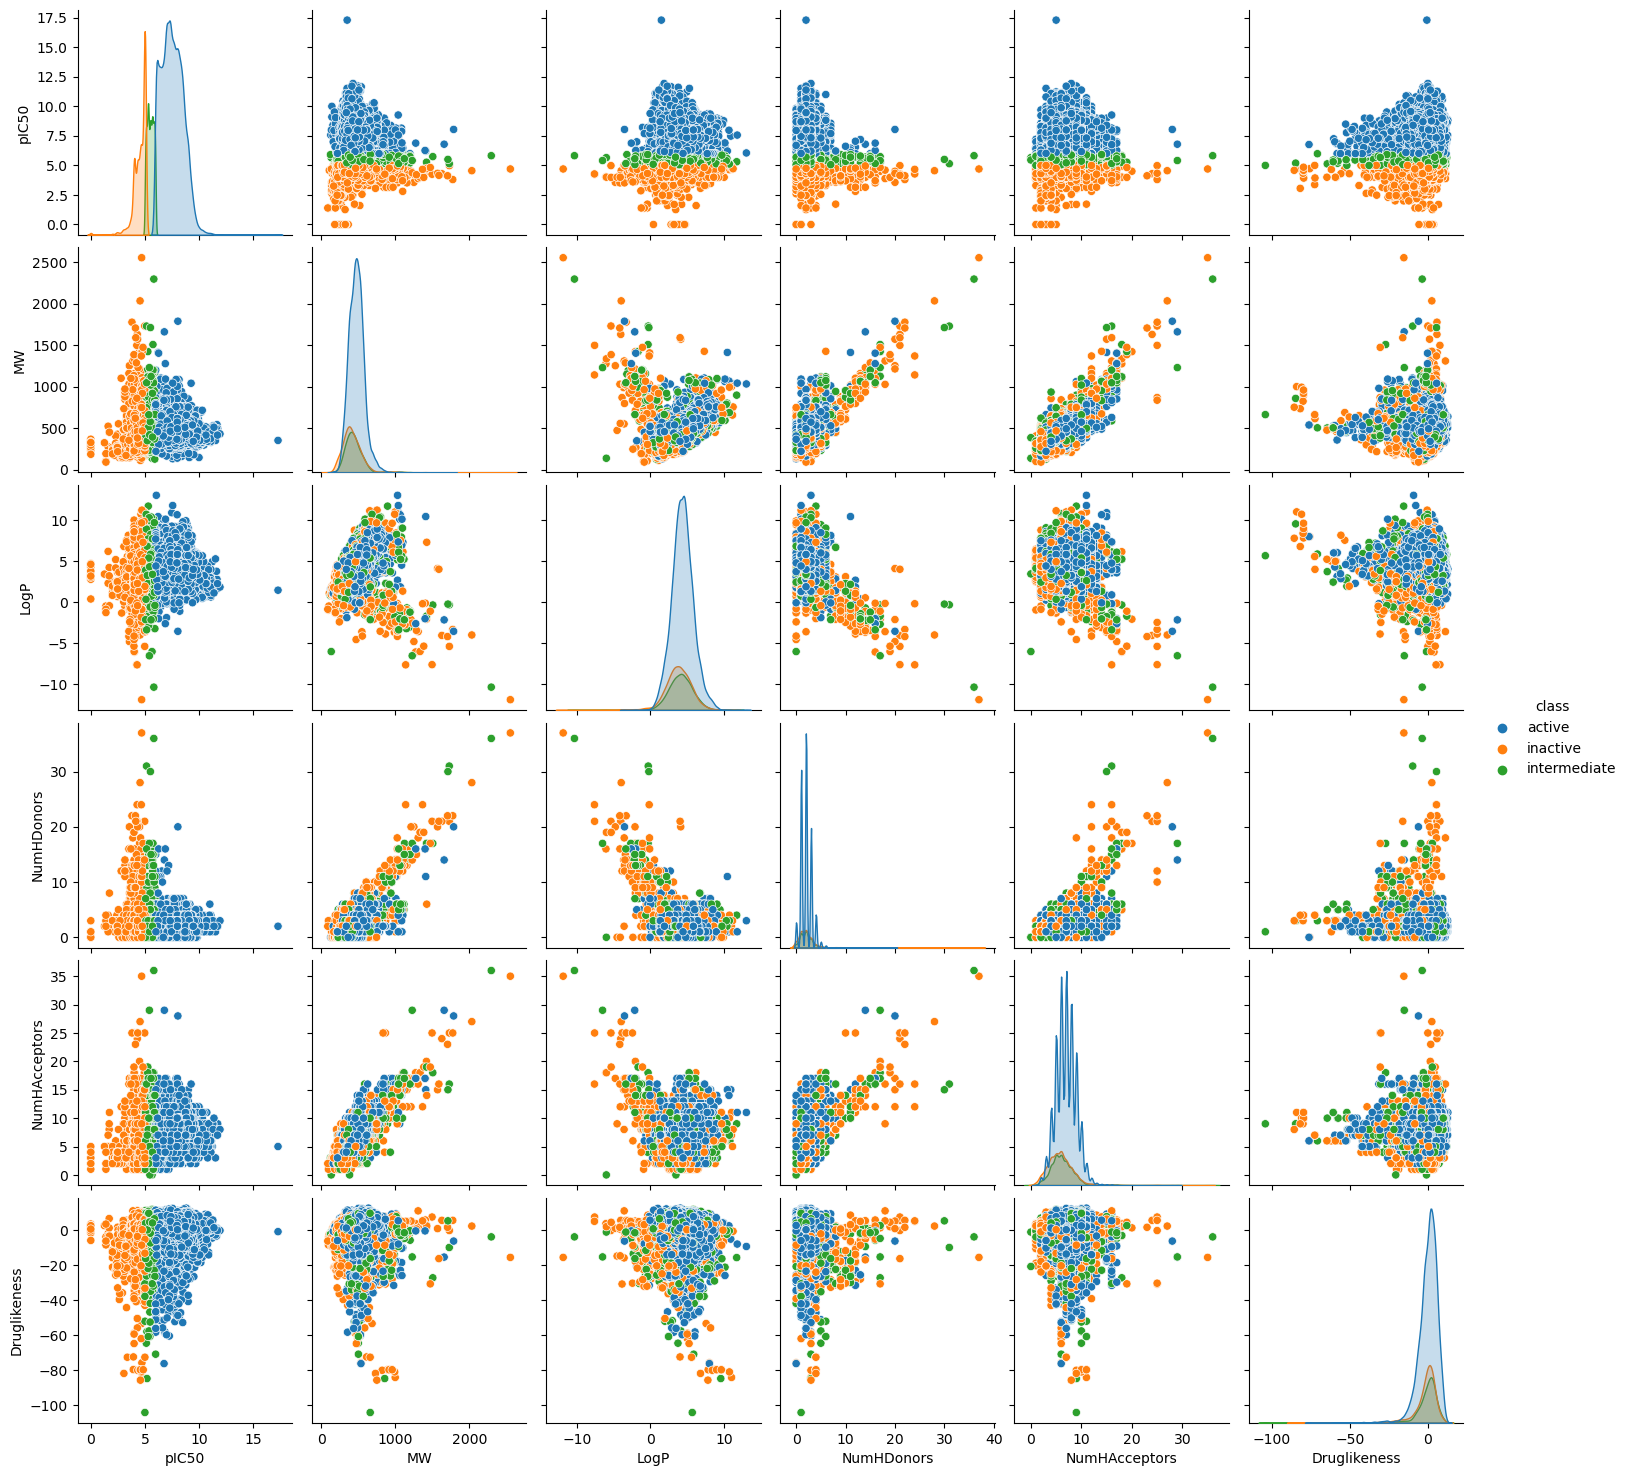

In [7]:
subset = drugs_dataset[["pIC50", "MW", "LogP", "NumHDonors", "NumHAcceptors", "Druglikeness", "class"]]
sns.pairplot(subset, hue = 'class')

We can see that pIC50 separates the activity classes, as established in the dataset description. Active compounds tend to have high LogP and low NumHDonors.

# Data preprocessing

In [9]:
# Shuffle the dataset 
drugs_dataset = drugs_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

## Molecular fingerprints

To convert the chemical structures into more appropriate inputs for the neural network, we will generate molecular fingerprints for each compound. We do so by applying a kernel to a molecule, which generates a bit or count vector. This is done using the package RDKit.
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In [10]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

Computing the fingerprints takes some time (10ish min) so I have run it once and now use the saved fingerprints

In [11]:
# Convert the canonical_smiles strings to RDKit molecules
compounds = [Chem.MolFromSmiles(smiles) for smiles 
             in drugs_dataset['canonical_smiles']]

# Generate the RDkit's version of Daylight fingerprints for each molecule
fingerprints = [Chem.RDKFingerprint(compound) for compound in compounds]

# Standarise input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fingerprints_scaled = scaler.fit_transform(fingerprints) 

# View & save scaled fingerprints, since scaling takes time
print(fingerprints_scaled[:5])
np.save('./fingerprints_scaled.npy', fingerprints_scaled)

[[ 0.23991246  0.7671586   0.88664923 ...  1.29282021  1.00007064
   0.3246043 ]
 [ 0.23991246 -1.30351143  0.88664923 ... -0.77350276  1.00007064
   0.3246043 ]
 [ 0.23991246 -1.30351143  0.88664923 ... -0.77350276  1.00007064
   0.3246043 ]
 [ 0.23991246  0.7671586  -1.12784173 ... -0.77350276  1.00007064
   0.3246043 ]
 [ 0.23991246 -1.30351143 -1.12784173 ... -0.77350276 -0.99992937
   0.3246043 ]]


In [12]:
# Load fingerprint data
fingerprints_scaled = np.load('./fingerprints_scaled.npy')

## Labels for bioactivity

In [13]:
activity_class = drugs_dataset["class"]

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
activity_encoded = label_encoder.fit_transform(activity_class)  # e.g., 'active' -> 0, 'inactive' -> 1, etc.
activity_1hot = to_categorical(activity_encoded)

In [15]:
# Check the mapping
print(label_encoder.classes_)
# So 0: active, 1: inactive, 2: intermediate

['active' 'inactive' 'intermediate']


# Characterize molecular fingerprints

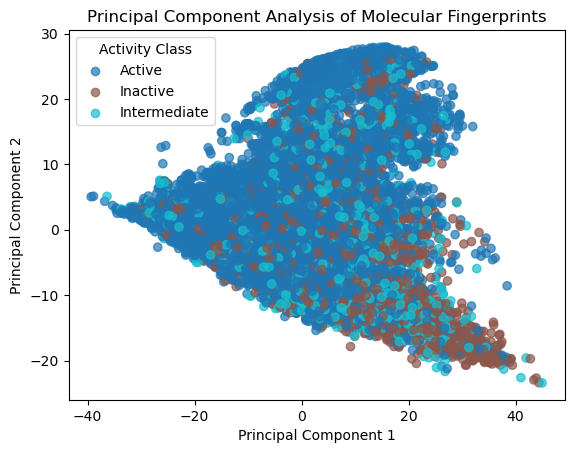

In [16]:
## Principal Component Analysis (PCA)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Run PCA, retain 20 components
transformed = PCA(n_components=20).fit_transform(fingerprints_scaled)

# Create scatter plot for first two principal components
scatter = plt.scatter(transformed[:, 0], transformed[:, 1], c=activity_encoded, cmap="tab10", alpha=0.7)

# Map encoded classes to labels
class_labels = {0: 'Active', 1: 'Inactive', 2: 'Intermediate'}
classes = np.unique(activity_encoded)
colors = scatter.cmap(scatter.norm(classes))

# Add dummy points for legend
for cls, color in zip(classes, colors):
    plt.scatter([], [], c=[color], label=class_labels[cls], alpha=0.7)

# Print the plot
plt.legend(title="Activity Class")
plt.title('Principal Component Analysis of Molecular Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


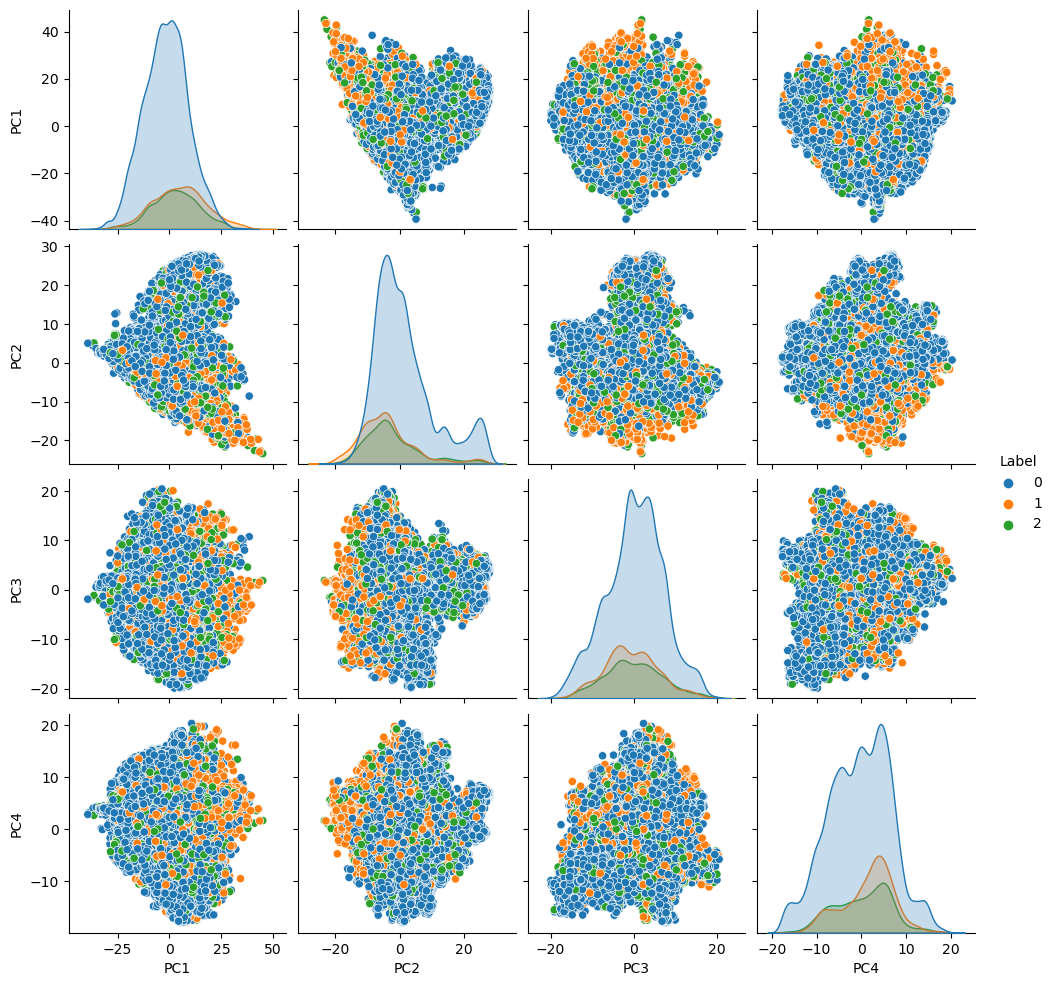

In [17]:
# Run PCA with 4 components for pairplot
transformed = PCA(n_components=4).fit_transform(fingerprints_scaled)
transformed_df = pd.DataFrame(transformed, columns=[f'PC{i+1}' for i in range(transformed.shape[1])])

# Add the labels as a new column
transformed_df['Label'] = activity_encoded

# Make the pairplot
sns.pairplot(transformed_df, hue='Label', palette = "tab10")

The molecular fingerprints don't form very clear clusters, so I suspect this may not be the easiest classification problem

# Important parameters: 

## Hyperparameters
I am considering the following hyperparameters:
- Learning rate: 
- Learning rate method: https://keras.io/api/optimizers/ 
- Activation function: linear, sigmoid, relu, softmax, tanh. Last layer will use softmax to determine which class is most likely.
- Number of layers
- Number of nodes per layer
- Epochs
- Batch size

- Loss function: https://keras.io/api/losses/. We have 2 or more label classes, one_hot representation. Therefore our options include
    - CategoricalCrossentropy class: 
    - CategoricalFocalCrossentropy: Handles class imbalance without using class_weights.

- Preventing overfitting: weight decay in some optimizers, adding dropout layers

Hyperparameter optimisation will be carried out using Optuna.


## Performance measures
- Correlation: not appropriate since we are predicting categorical variables based on non-numerical input.
- PPV: Positive Predictive Value: No. of true positives/No. of true positives + No. of false positives
- F1: 2TP/(2TP + FP + FN)
- ROS: False positive vs. True positive; AUC: Area under the ROC curve 

I will be using a confusion matrix to easily visualize false & true positive rates in relation to each other. 

Cross-validation: 20% test data, 60% training data, 20% validation data. 


# Training & test sets

In [18]:
testset_size = round(fingerprints_scaled.shape[0] * 0.2) # 20% of the dataset is the test set

# Define test and training sets
test_x = fingerprints_scaled[:testset_size,:]
test_y = activity_1hot[:testset_size]

train_x = fingerprints_scaled[testset_size:,:]
train_y = activity_1hot[testset_size:]

In [19]:
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

(5663, 2048)
(5663, 3)
(22651, 2048)
(22651, 3)


In [24]:
# Get a sense for the range of scaled fingerprints
print(np.min(fingerprints_scaled))
print(np.max(fingerprints_scaled))

-22.0719825523969
2.1962534944229346


In a more comprehensive analysis, we could calculate similarity metrics between different compounds based on their fingerprints to better ensure that the test set is quite different from the training set. However, this is beyond the scope of this assignment.

# Neural Net 1

## Construct model

In [102]:
from tensorflow.keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

num_classes = 3
epochs = 100
batch_size = 32

In [103]:
model = Sequential()
model.add(Input(shape=train_x.shape[1:]))

model.add(Dense(115, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(40, activation='relu'))

model.add(Dense(num_classes, activation = 'softmax'))

# Let's train the model using RMSprop
model.compile(optimizer= Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 115)               235635    
_________________________________________________________________
dropout_28 (Dropout)         (None, 115)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 40)                4640      
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 123       
Total params: 240,398
Trainable params: 240,398
Non-trainable params: 0
_________________________________________________________________


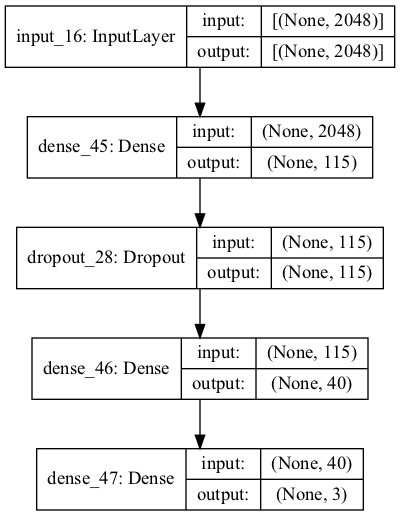

In [104]:
from keras.utils import plot_model
plot_model(model, "./simplenet_model.png", show_shapes=True)

## Train model

In [105]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

hist = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
567/567 [==============================] - 2s 3ms/step - loss: 0.8910 - accuracy: 0.6595 - val_loss: 0.5738 - val_accuracy: 0.7661
Epoch 2/100
567/567 [==============================] - 1s 2ms/step - loss: 0.5797 - accuracy: 0.7686 - val_loss: 0.5346 - val_accuracy: 0.7897
Epoch 3/100
567/567 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7835 - val_loss: 0.5216 - val_accuracy: 0.7934
Epoch 4/100
567/567 [==============================] - 1s 2ms/step - loss: 0.4851 - accuracy: 0.8029 - val_loss: 0.5199 - val_accuracy: 0.7947
Epoch 5/100
567/567 [==============================] - 1s 2ms/step - loss: 0.4769 - accuracy: 0.8092 - val_loss: 0.5095 - val_accuracy: 0.7965
Epoch 6/100
567/567 [==============================] - 1s 2ms/step - loss: 0.4510 - accuracy: 0.8184 - val_loss: 0.4998 - val_accuracy: 0.8003
Epoch 7/100
567/567 [==============================] - 1s 2ms/step - loss: 0.4273 - accuracy: 0.8272 - val_loss: 0.4982 - val_accuracy: 0.8069

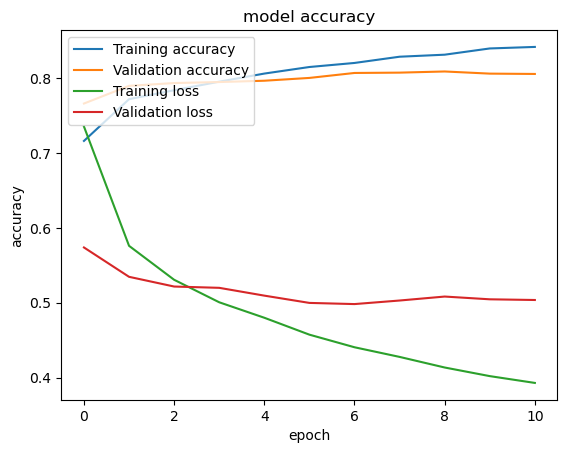

In [106]:
from matplotlib.ticker import MaxNLocator

%matplotlib inline

def plot_loss_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer ticks on x-axis

    plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'], loc='upper left')
    plt.show()
    
plot_loss_acc(hist)

## Test model

In [107]:
# Test the basic classification model
scores = model.evaluate(test_x, test_y)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

177/177 [==============================] - 0s 814us/step - loss: 0.5091 - accuracy: 0.7955
Test loss: 0.5090932846069336
Test accuracy: 0.7955147624015808


In [108]:
y_pred_probs = model.predict(test_x)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_y, axis=1)

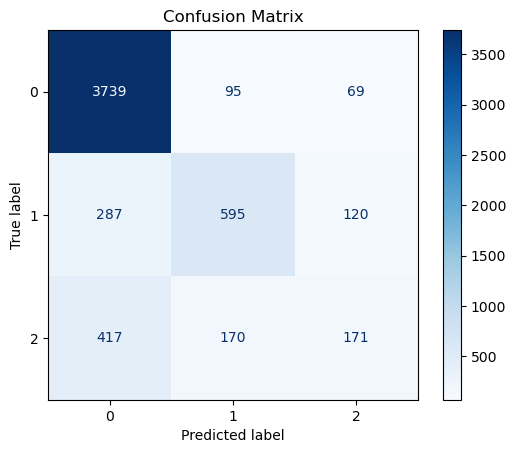

In [109]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
import matplotlib.pyplot as plt

# Convert predictions from 1-hot to classes
y_pred_probs = model.predict(test_x) 
y_pred = np.argmax(y_pred_probs, axis=1)     

# Convert true labels from 1-hot to classes
y_true = np.argmax(test_y, axis=1) 

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix: absolute numbers
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


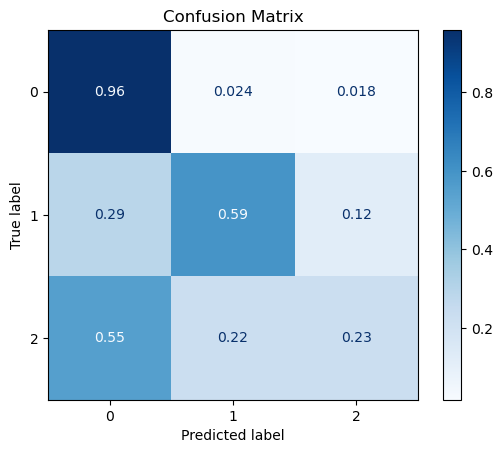

In [110]:
# Compute the confusion matrix: normalized by true labels
cm = confusion_matrix(y_true, y_pred, normalize = "true")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Most active compounds (96%) were correctly classified. 59% of inactive compounds were correctly classified, while only 23% of intermediate compounds were correctly classified. The intermediate class was the most "difficult" for the network to correctly predict. 

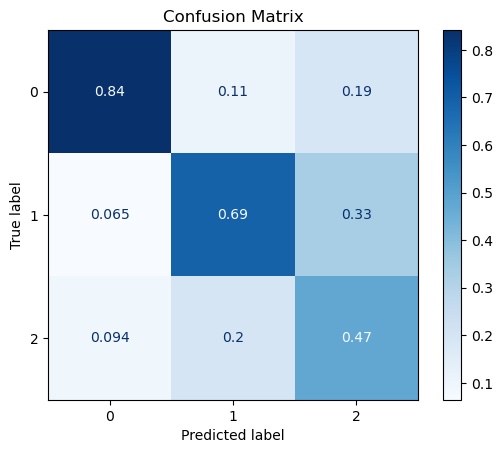

In [111]:
# Compute the confusion matrix: normalized by predicted labels
cm = confusion_matrix(y_true, y_pred, normalize = "pred")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Around 84% of compounds classified as "active" were in fact active; 69% of compounds classified as inactive were in fact inactive, and 47% of compounds classified as intermediate were intermediate.

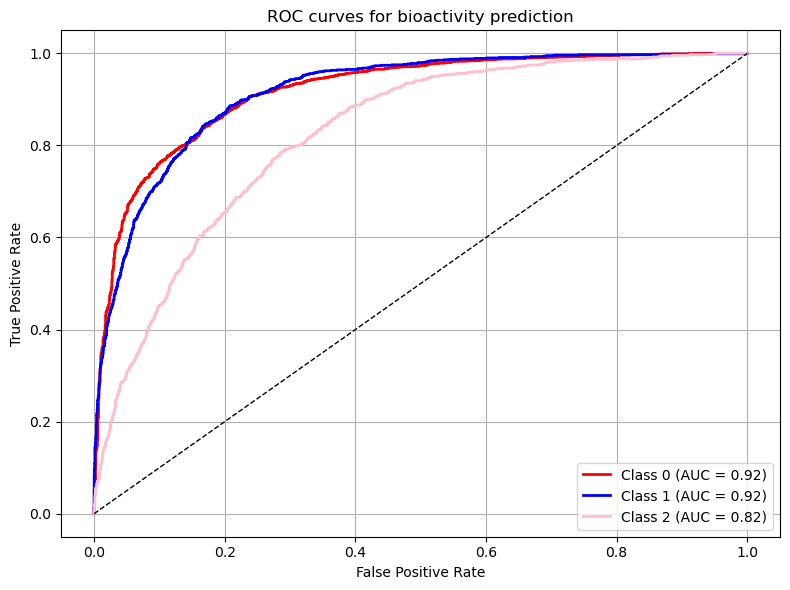

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = test_y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'pink'] 
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Add diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for bioactivity prediction')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


## Model 2: Optimized hyperparameters

## Construct model skeleton

Testing Optuna to tune hyperparameters and evaluate performance

In [42]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

Model training (create_model) is wrapped inside an objective function, along with a parameter to maximize (validation accuracy in our case). 

In [43]:
# Create a model based on the basic architecture
def create_model(trial):

    # We want a sequential model with the input shape defined
    model = Sequential()
    model.add(Input(shape=train_x.shape[1:]))

    # Tune number of units (i.e. nodes) and the activation function
    num_units = trial.suggest_int('units', 16, 200)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])

    # Add two hidden layers with the tuned parameters
    model.add(Dense(num_units, activation=activation))
    model.add(Dropout(0.5))

    model.add(Dense(num_units, activation=activation))
    model.add(Dropout(0.5))


    # Output layer with 3 classes, and softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Tune optimizer and learning rate
    optimizer_name = trial.suggest_categorical('optimizer', ['RMSprop', 'Adam'])
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    if optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate, decay=1e-6)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the aim of the optimization
def objective(trial):

    # Call upon the model created by the create_model function
    model = create_model(trial)
    
    # Tune batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Fit the model
    history = model.fit(train_x, train_y,
                        validation_split=0.2,
                        epochs=30,
                        batch_size=batch_size,
                        verbose=0)
    
    # Extract validation accuracy from the history
    val_acc = history.history['val_accuracy'][-1]
    
    # Return validation accuracy
    return val_acc


## Tune parameters for model

In [44]:
# Create an Optuna study to maximize the objective
study = optuna.create_study(direction='maximize') # We want to maximize validation accuracy
study.optimize(objective, n_trials=10) # Start optimization

[I 2025-06-15 00:11:30,237] A new study created in memory with name: no-name-ace097e0-de0f-4fe7-a6e3-3a7bd465f21a
[I 2025-06-15 00:11:51,803] Trial 0 finished with value: 0.8128448724746704 and parameters: {'units': 101, 'activation': 'sigmoid', 'optimizer': 'Adam', 'lr': 0.0033919952458680647, 'batch_size': 128}. Best is trial 0 with value: 0.8128448724746704.
[I 2025-06-15 00:12:17,885] Trial 1 finished with value: 0.8090929388999939 and parameters: {'units': 58, 'activation': 'tanh', 'optimizer': 'RMSprop', 'lr': 0.00021837717764181983, 'batch_size': 32}. Best is trial 0 with value: 0.8128448724746704.
[I 2025-06-15 00:12:52,516] Trial 2 finished with value: 0.800926923751831 and parameters: {'units': 28, 'activation': 'tanh', 'optimizer': 'RMSprop', 'lr': 0.00010857710427928352, 'batch_size': 16}. Best is trial 0 with value: 0.8128448724746704.
[I 2025-06-15 00:13:19,918] Trial 3 finished with value: 0.8090929388999939 and parameters: {'units': 183, 'activation': 'relu', 'optimizer

## Identify & reconstruct the best model

In [45]:
# Summarize results of optimization study
print("Best trial:")
trial = study.best_trial

# Print detaills of each trial
print(f"  Validation Accuracy: {trial.value}")
print("  Parameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Validation Accuracy: 0.8128448724746704
  Parameters: 
    units: 101
    activation: sigmoid
    optimizer: Adam
    lr: 0.0033919952458680647
    batch_size: 128


In [46]:
params = study.best_trial.params
params

{'units': 101,
 'activation': 'sigmoid',
 'optimizer': 'Adam',
 'lr': 0.0033919952458680647,
 'batch_size': 128}

In [53]:
# Test the model suggested by Optuna

model2 = Sequential()
model2.add(Input(shape=train_x.shape[1:]))

# Add two hidden layers with the tuned parameters
model2.add(Dense(params['units'], activation=params['activation']))
model2.add(Dropout(0.5))

model2.add(Dense(params['units'], activation=params['activation']))
model2.add(Dropout(0.5))


# Output layer with 3 classes, and softmax activation
model2.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=params['lr'])

# Compile the model
model2.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
hist2 = model2.fit(train_x, train_y,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=params['batch_size'],
                    verbose=0, 
                    callbacks=[early_stop])

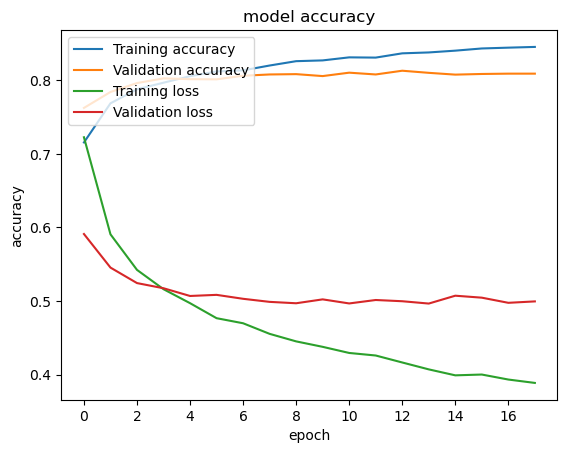

In [54]:
plot_loss_acc(hist2)

## Test optimized model

In [121]:
scores = model2.evaluate(test_x, test_y)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

177/177 [==============================] - 0s 893us/step - loss: 0.5058 - accuracy: 0.8015
Test loss: 0.5057557225227356
Test accuracy: 0.8015186190605164


In [122]:
y_pred_probs = model2.predict(test_x)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_y, axis=1)

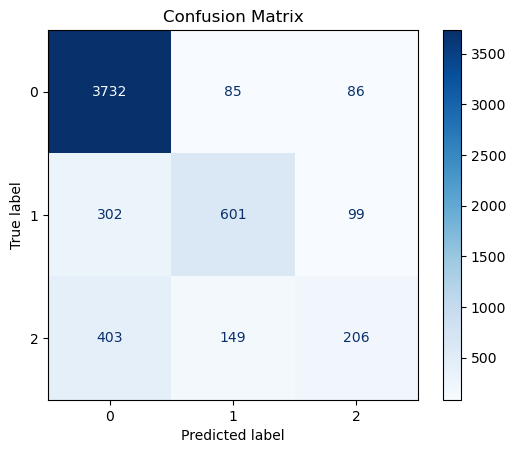

In [123]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
import matplotlib.pyplot as plt

# Convert predictions from 1-hot to classes
y_pred_probs = model2.predict(test_x) 
y_pred = np.argmax(y_pred_probs, axis=1)     

# Convert true labels from 1-hot to classes
y_true = np.argmax(test_y, axis=1) 

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

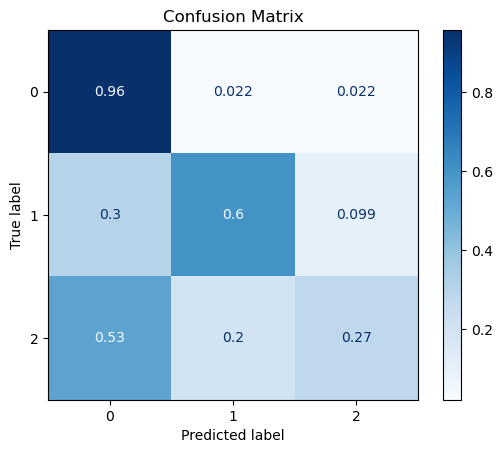

In [124]:
# Compute the confusion matrix: normalized by true labels
cm = confusion_matrix(y_true, y_pred, normalize = "true")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

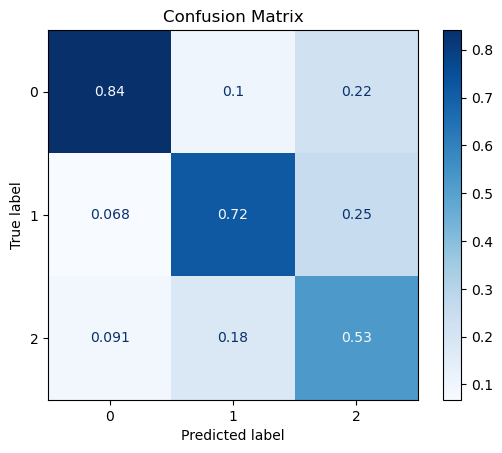

In [125]:
# Compute the confusion matrix: normalized by predicted labels
cm = confusion_matrix(y_true, y_pred, normalize = "pred")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      3903
           1       0.72      0.60      0.65      1002
           2       0.53      0.27      0.36       758

    accuracy                           0.80      5663
   macro avg       0.70      0.61      0.64      5663
weighted avg       0.78      0.80      0.78      5663



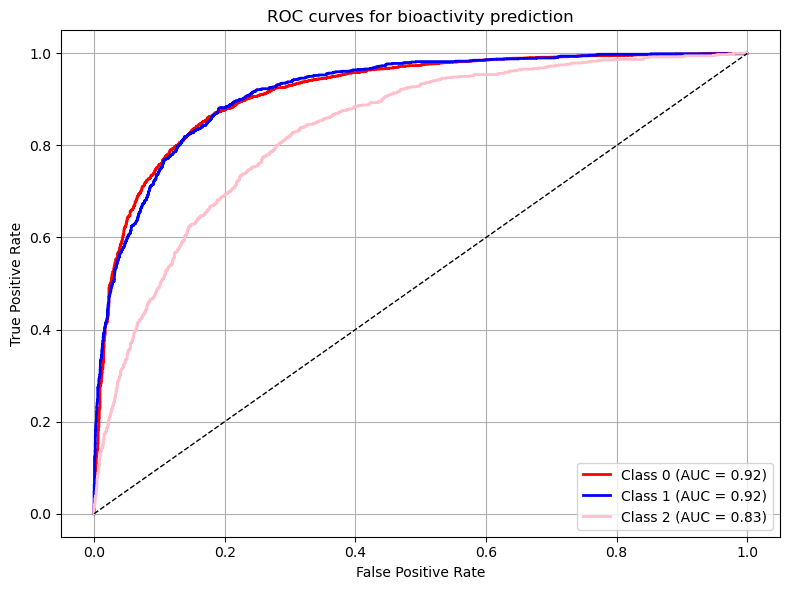

In [127]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = test_y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'pink'] 
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Add diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for bioactivity prediction')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


## Conclusions
I was able to achieve ~80% accuracy over many manual iterations and after using an optimizer for the hyperparameters. If the neural net used the most common label (active) for all its predictions, it would get ~70% accuracy, so the validation and test accuracies needed to be above this threshold.

During my manual iterations, the loss function was very high until I included dropout layer to minimize overfitting. In the future, k-fold cross validation could be included to improve performance. 

One may also consider including molecular weight (MW) and Drug-likeness as inputs into the model since this information would be readily available for any synthesized compound without experimental followup. However, it was an intriguing prospect to attempt this assignment with only the molecular fingerprints. 

Other possible questions one could address with this dataset
- What is the compound's mutagenicity? none/low/high
- What is the compound's tumorigenecity?
- What is the compound's reproductive toxicity?
- What is the compound's irritation level?
- etc.